In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle

color_dict = {
        "Uni-RNA": "#D95F02",
        "MXfold2": "#C06FA9",
        "RNA-FM": "#B78FB2",
        "MXfold": "#97B3C5",
        "LinearFold": "#B1A471",
        "RNAfold": "#70A56E",
        "RNAstructure": "#E5ADA8",
        "ProbKnot": "#E96692",
        "CONTRAFold": "#E4B488",
        "IPknot": "#78B4A8"
    }
# 78B4A8 DAA0A0

import torch
torch.cuda.set_device(2)

### utils

In [2]:
import numpy as np

def convert_dotbracket_to_matrix(s):
    m = np.zeros([len(s), len(s)])
    for char_set in [['(', ')'], ['[', ']'], ['{', '}'], ['<', '>']]:
        bp1 = []
        bp2 = []
        for i, char in enumerate(s):
            if char == char_set[0]:
                bp1.append(i)
            if char == char_set[1]:
                bp2.append(i)
        for i in list(reversed(bp1)):
            for j in bp2:
                if j > i:
                    m[i, j] = 1.0
                    bp2.remove(j)
                    break
    return m + m.T


def convert_matrix_to_dotbracket(m):
    bp_list = convert_matrix_to_bp_list(m)
    return convert_bp_list_to_dotbracket(bp_list, len(m))


def convert_matrix_to_bp_list(m):
    bp_list = []  # convert adjacency matrix to adjacency list
    for i, row in enumerate(m):
        for j, is_bp in enumerate(row[i + 1:]):
            if is_bp:
                bp_list.append((i, i + 1 + j))
    return bp_list


def convert_bp_list_to_dotbracket(bp_list,seq_len):
    dotbracket = "."*seq_len
    # group into bps that are not intertwined and can use same brackets!
    groups = group_into_non_conflicting_bp_(bp_list)

    # all bp that are not intertwined get (), but all others are
    # groups to be nonconflicting and then asigned (), [], {}, <> by group
    chars_set = [("(", ")"), ("(", ")"), ("[", "]"), ("{", "}"), ("<", ">")]
    if len(groups) > len(chars_set):
        print(f"WARNING: PK too complex with {len(groups)} groups, not enough brackets to represent it.")

    for group,chars in zip(groups,chars_set):
        for bp in group:
            dotbracket = dotbracket[:bp[0]] + chars[0] + dotbracket[bp[0]+1:bp[1]] + chars[1] + dotbracket[bp[1]+1:]
    return dotbracket


def load_matrix_or_dbn(s):
    num_lines = sum(1 for line in open(s))

    if num_lines > 2:  # heuristic here
        struct = np.loadtxt(s)  # load as base pair matrix
        assert struct.shape[0] == struct.shape[1]
    else:
        try:  # load as dot-bracket string

            dbn_struct = open(s, 'r').read().rstrip()

            struct = convert_dotbracket_to_matrix(dbn_struct)
        except:
            raise ValueError('Unable to parse structure %s' % s)
    return struct


def group_into_non_conflicting_bp_(bp_list):
    ''' given a conflict list from get_list_bp_conflicts_, group basepairs into groups that do not conflict

    Args
        conflict_list: list of pairs of base_pairs that are intertwined basepairs

    Returns:
        groups of baspairs that are not intertwined
    '''
    conflict_list = get_list_bp_conflicts_(bp_list)

    non_redudant_bp_list = get_non_redudant_bp_list_(conflict_list)
    bp_with_no_conflict = [bp for bp in bp_list if bp not in non_redudant_bp_list]
    groups = [bp_with_no_conflict]
    while non_redudant_bp_list != []:
        current_bp = non_redudant_bp_list[0]
        current_bp_conflicts = []
        for conflict in conflict_list:
            if current_bp == conflict[0]:
                current_bp_conflicts.append(conflict[1])
            elif current_bp == conflict[1]:
                current_bp_conflicts.append(conflict[0])
        group = [bp for bp in non_redudant_bp_list if bp not in current_bp_conflicts]
        groups.append(group)
        non_redudant_bp_list = current_bp_conflicts
        conflict_list = [conflict for conflict in conflict_list if
                         conflict[0] not in group and conflict[1] not in group]
    return groups


def get_list_bp_conflicts_(bp_list):
    '''given a bp_list gives the list of conflicts bp-s which indicate PK structure
    Args:
        bp_list: of list of base pairs where the base pairs are list of indeces of the bp in increasing order (bp[0]<bp[1])
    returns:
        List of conflicting basepairs, where conflicting is pairs of base pairs that are intertwined.
    '''
    if len(bp_list) <= 1:
        return []
    else:
        current_bp = bp_list[0]
        conflicts = []
        for bp in bp_list[1:]:
            if (bp[0] < current_bp[1] and current_bp[1] < bp[1]):
                conflicts.append([current_bp, bp])
        return conflicts + get_list_bp_conflicts_(bp_list[1:])


def get_non_redudant_bp_list_(conflict_list):
    ''' given a conflict list get the list of nonredundant basepairs this list has

    Args:
        conflict_list: list of pairs of base_pairs that are intertwined basepairs
    returns:
        list of basepairs in conflict list without repeats
    '''
    non_redudant_bp_list = []
    for conflict in conflict_list:
        if conflict[0] not in non_redudant_bp_list:
            non_redudant_bp_list.append(conflict[0])
        if conflict[1] not in non_redudant_bp_list:
            non_redudant_bp_list.append(conflict[1])
    return non_redudant_bp_list

import re
import math
import numpy as np

def adjacency_matrix_to_bpseq(adj_matrix):
    L = len(adj_matrix)
    bpseq = [-1] * L  # 初始化bpseq列表，假设所有位置最初都没有配对

    for i in range(L):
        for j in range(L):
            if adj_matrix[i][j] == 1:
                bpseq[i] = j
                break  # 当找到配对时，跳出内层循环

    return bpseq

def compute_expected_accuracy(etp, efp, efn):
    sen = ppv = f = 0.
    if etp + efn != 0:
        sen = etp / (etp + efn)
    else:
        sen = 0.
        
    if etp + efp != 0:
        ppv = etp / (etp + efp)
    else:
        ppv = 0.
        
    if sen + ppv != 0:
        f = 2 * sen * ppv / (sen + ppv)
    else:
        f = 0.

    return (sen, ppv, f)

def compute_expected_accuracy_pk(pred, label):
    
    # L = len(label)
    # L2 = L * (L - 1) // 2
    N = 0
    pk_flag = False
    
    sump = 0.0
    etp = 0.0
    
    for i in range(len(label)):
        j = label[i]
        if i < j:
            for k in range(i + 1, j):
                l = label[k]
                lp = pred[k]
                if j < lp:
                    N += 1 # TP+FP
                if j < l:
                    sump += 1 # TP+FN
                    if pred[i] == j and pred[k] == l:
                        etp += 1 # TP
    
    efp = N - etp
    efn = sump - etp
    
    if sump > 0:
        pk_flag = True

    return compute_expected_accuracy(etp, efn, efp), pk_flag

def apc(x):
    "Perform average product correct, used for contact prediction."
    a1 = x.sum(-1, keepdims=True)
    a2 = x.sum(-2, keepdims=True)
    a12 = x.sum((-1, -2), keepdims=True)

    avg = a1 * a2
    avg.div_(a12)  # in-place to reduce memory
    normalized = x - avg
    return normalized

## Benchmark-1

### Preprocessing

In [3]:
ckpt_unirna = "/mnt/wangxi/ss-log/ss-bh1/new-idt75-b4g16-Auto-_data_weights_unirna_L16_E1024_DPRNA500M_STEP400K_-fusion-null-c9705029-1fc3ca/W6Lk02T99/checkpoints/epoch-16.pth"
ckpt_fm = "/mnt/wangxi/ss-log/ss-bh1/fm-new-idt75-b4g16-Auto-_home_wangxi_develop_rnafm_transformers_RNA-FM_pretrained-fusion-null-c9705029-a2ce71/W70NX2NTh/checkpoints/epoch-11.pth"
ckpt_rinalmo = "/mnt/wangxi/ss-log/ss-bh1/idt75-b1g16-rinalmo-Auto-multimolecule_rinalmo-fusion-null-71499ea0-4fdd48/k5GRN2bdg/checkpoints/best.pth"
data_list = "/mnt/siduanmiao/RNAstru_benchmark/all_data_1024_0.75/benchmark_1/length_level/test.pkl"

from deepprotein.runners.inferencer import LazyInferencer
    
if not os.path.exists("result_unirna.pkl"):
    infer = LazyInferencer(ckpt_unirna, batch_size=1)
    result_unirna = infer.run(data_list)
    with open("result_unirna.pkl", "wb+") as f:
        pickle.dump(result_unirna, f)
else:
    with open("result_unirna.pkl", "rb") as f:
        result_unirna = pickle.load(f)

import rnafm  
infer_fm = LazyInferencer(ckpt_fm, batch_size=1, sequence_pretrained="/home/wangxi/develop/rnafm_transformers/RNA-FM_pretrained")       
if not os.path.exists("result_fm.pkl"):
    result_fm = infer_fm.run(data_list)
    with open("result_fm.pkl", "wb+") as f:
        pickle.dump(result_fm, f)
else:
    with open("result_fm.pkl", "rb") as f:
        result_fm = pickle.load(f)
        
if not os.path.exists("result_rinalmo.pkl"):
    infer_rinalmo = LazyInferencer(ckpt_rinalmo, batch_size=1)
    result_rinalmo = infer_rinalmo.run(data_list)
    with open("result_rinalmo.pkl", "wb+") as f:
        pickle.dump(result_rinalmo, f)
else:
    with open("result_rinalmo.pkl", "rb") as f:
        result_rinalmo = pickle.load(f)

/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/deepprotein/runners/evaluator.py:12: FutureWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  class Evaluator(DeepProteinRunner):
/home/wangxi/miniforge3/envs/torch/lib/python3.10/site-packages/danling/utils/io.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling 

In [4]:
data_label = pickle.load(open(data_list, "rb"))
data_dir = "/mnt/siduanmiao/benchmark_store_sdm/changeformatdata/"
benchmark_name = "benchmark_1_0.75_length_level.pkl"
all_method = os.listdir(data_dir)
all_method.remove("SPOTRNA")

In [5]:
all_method[all_method.index("mxfold2")] = "MXfold2"
all_method[all_method.index("mxfold")] = "MXfold"
all_method[all_method.index("linearFold")] = "LinearFold"
all_method[all_method.index("contrafold")] = "CONTRAFold"
all_method[all_method.index("ipknot")] = "IPknot"

In [6]:
all_method

['IPknot',
 'ProbKnot',
 'MXfold2',
 'MXfold',
 'RNAstructure',
 'LinearFold',
 'RNAfold',
 'CONTRAFold']

In [7]:
import os
import pickle 
import numpy as np
import warnings
from tqdm import tqdm
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

all_pred_unirna = []
all_pred_fm = []

unirna_score = []
unirna_score_pk = []
unirna_score_pk_sample = []

fm_score = []
fm_score_pk = []
fm_score_pk_sample = []

rinalmo_score = []
rinalmo_score_pk = []
rinalmo_score_pk_sample = []

all_label = []

methods_pred = []
methods_score = []
methods_score_pk = []
methods_score_pk_sample = []

unirna_pk_index = []
fm_pk_index = []
rinalmo_pk_index = []

length_list = []

for i in tqdm(range(len(data_label))):
    id = data_label[i]['id']
    label = data_label[i]['label']
    all_label.extend(label.reshape(-1).tolist())
    length_list.append(len(data_label[i]['seq']))
    pred = np.array(result_unirna["label"][i])
    all_pred_unirna.extend(pred.reshape(-1).tolist())
    pred = np.where(pred > 0.5, 1, 0)
    f1 = f1_score(label.reshape(-1), pred.reshape(-1))
    unirna_score.append(f1)
    pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(pred), adjacency_matrix_to_bpseq(label))
                                              
    if pk_metrics[-1]:
        unirna_score_pk.append(pk_metrics[0][-1])
        unirna_score_pk_sample.append(f1)
        unirna_pk_index.append(i)
    
    pred_fm = np.array(result_fm["label"][i])
    all_pred_fm.extend(pred_fm.reshape(-1).tolist())
    pred_fm = np.where(pred_fm > 0.5, 1, 0)
    f1 = f1_score(label.reshape(-1), pred_fm.reshape(-1))
    fm_score.append(f1)
    
    pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(pred_fm), adjacency_matrix_to_bpseq(label))
    if pk_metrics[-1]:
        fm_score_pk.append(pk_metrics[0][-1])
        fm_score_pk_sample.append(f1)
        fm_pk_index.append(i)
        
    pred_rinalmo = np.array(result_rinalmo["label"][i])
    pred_rinalmo = np.where(pred_rinalmo > 0.5, 1, 0)
    f1 = f1_score(label.reshape(-1), pred_rinalmo.reshape(-1))
    rinalmo_score.append(f1)
    
    pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(pred_rinalmo), adjacency_matrix_to_bpseq(label))
    if pk_metrics[-1]:
        rinalmo_score_pk.append(pk_metrics[0][-1])
        rinalmo_score_pk_sample.append(f1)
        rinalmo_pk_index.append(i)
    

100%|██████████| 1041/1041 [02:38<00:00,  6.55it/s]


In [8]:
np.array(unirna_score).mean(), np.array(fm_score).mean(), np.array(rinalmo_score).mean()

(np.float64(0.6678832671032261),
 np.float64(0.6481737992732549),
 np.float64(0.6679636484275312))

In [ ]:
print(all_method)
for method in all_method:
    
    single_method = []
    single_method_score = []
    single_method_index_pk = []
    single_method_score_pk = []
    single_method_score_pk_sample = []
    
    method_path = os.path.join(data_dir, method, benchmark_name)
    print("extract from {}".format(method))
    print(method_path)
    data = pickle.load(open(method_path, "rb"))
    for i in tqdm(range(len(data_label))):
        method_pred = np.array(data[i]["label"])
        label = data_label[i]['label']
        method_pred = np.where(method_pred > 0.5, 1, 0)
        f1 = f1_score(label.reshape(-1), method_pred.reshape(-1))
        single_method_score.append(f1)
        pk_metrics = compute_expected_accuracy_pk(adjacency_matrix_to_bpseq(method_pred), adjacency_matrix_to_bpseq(label))
        if pk_metrics[-1]:
            single_method_score_pk.append(pk_metrics[0][-1])
            single_method_score_pk_sample.append(f1)
            single_method_index_pk.append(i)
        single_method.extend(method_pred.reshape(-1).tolist())
        
    if np.sum(np.array(single_method_index_pk) - np.array(unirna_pk_index)) != 0:
        print("PK index not match")
        
    methods_pred.append(single_method)
    methods_score.append(single_method_score)
    methods_score_pk.append(single_method_score_pk)
    methods_score_pk_sample.append(single_method_score_pk_sample)

In [9]:
if os.path.exists("data-for-draw-idt5-box-pk.pkl"):
    scores_pk = pickle.load(open("data-for-draw-idt5-box-pk.pkl", "rb"))
else:
    scores_pk = [unirna_score_pk, fm_score_pk, rinalmo_score_pk] + methods_score_pk
    
if os.path.exists("data-for-draw-idt5-box.pkl"):
    scores = pickle.load(open("data-for-draw-idt5-box.pkl", "rb"))
else:
    scores = [unirna_score, fm_score, rinalmo_score] + methods_score
    with open("data-for-draw-idt5-box.pkl", "wb+") as f:
        pickle.dump(scores, f)
    
if os.path.exists("data-for-draw-idt5-box-pk-sample.pkl"):  
    scores_pk_sample = pickle.load(open("data-for-draw-idt5-box-pk-sample.pkl", "rb"))
else:
    scores_pk_sample = [unirna_score_pk_sample, fm_score_pk_sample, rinalmo_score_pk_sample] + methods_score_pk_sample
    with open("data-for-draw-idt5-box-pk-sample.pkl", "wb+") as f:
        pickle.dump(scores_pk_sample, f)

### F1 and Boxplot

In [12]:
length_list = [len(data_label[i]['seq']) for i in range(len(data_label))]

#### Crossing base pairs

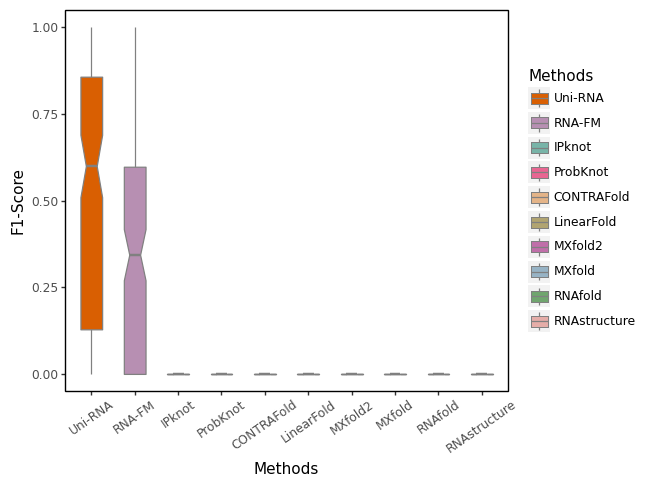

In [15]:
import pandas as pd
import random
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_x_discrete, \
    theme, element_text, stat_summary, scale_fill_manual, scale_color_manual, element_line, element_rect, geom_errorbar

def plot_box(scores, method_names):
    """
    使用 plotnine 绘制盒型图以比较不同方法的性能。
    """
    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Methods', 'Score'])

    # 将得分数据添加到DataFrame中
    for method_name, score_list in zip(method_names, scores):
        temp_df = pd.DataFrame({
            'Methods': [method_name] * len(score_list),
            'Score': score_list
        })
        df = pd.concat([df, temp_df], ignore_index=True)

    # 计算每种方法的平均分数并按这些分数排序
    mean_scores = df.groupby('Methods').mean().sort_values('Score', ascending=False)
    sorted_methods = mean_scores.index.tolist()

    # 重新排序原始DataFrame
    df['Methods'] = pd.Categorical(df['Methods'], categories=sorted_methods, ordered=True)
    df = df.sort_values('Methods')
    
    # 计算每个 'Methods' 的四分位数
    Q1 = df.groupby('Methods')['Score'].quantile(0.25)
    Q3 = df.groupby('Methods')['Score'].quantile(0.75)
    IQR = Q3 - Q1

    # 剪裁超过一定范围的值
    df_outlier_removed = df.copy()
    for method in df['Methods'].unique():
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] < (Q1[method] - 1.5 * IQR[method])), 'Score'] = Q1[method] - 1.5 * IQR[method]
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] > (Q3[method] + 1.5 * IQR[method])), 'Score'] = Q3[method] + 1.5 * IQR[method]
    
    plot = (
    ggplot(df_outlier_removed, aes(x='Methods', y='Score')) +
    geom_boxplot(aes(fill='Methods'), notch=True, width=0.5, color='gray', outlier_alpha=0.3, outlier_color="#97B3C5") +  # 设置盒型图的填充颜色和边缘颜色
    labs(x='Methods', y='F1-Score') +
    scale_fill_manual(values=color_dict) + 
    scale_x_discrete(limits=sorted_methods) +
    theme(
        axis_text_x=element_text(angle=35, hjust=4),
        panel_background=element_rect(fill='white'),  # 设置背景颜色为白色
        # panel_grid_major=element_line(color='grey', linetype="dashed"),  # 设置主要网格线颜色为灰色
        # panel_grid_minor=element_line(color='black', linetype="dashed"),  # 设置次要网格线颜色为浅灰色
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)
    return plot

if "SPOTRNA" in all_method:
    all_method.remove("SPOTRNA")

method_names = ["Uni-RNA", "RNA-FM"] + all_method

if not os.path.exists("data-for-draw-idt5-box-pk.pkl"):
    scores = [unirna_score_pk, fm_score_pk] + methods_score_pk
    with open("data-for-draw-idt5-box.pkl", "wb+") as f:
        pickle.dump(scores, f)
else:
    scores = pickle.load(open("data-for-draw-idt5-box-pk.pkl", "rb"))
    
plot = plot_box(scores, method_names)
plot.save("idt5-box-pk.svg", dpi=600)
plot.draw()

In [16]:
len(scores[0])

164

In [17]:
for i in range(len(method_names)):
    print(method_names[i], np.mean(scores[i]))

Uni-RNA 0.5255659799623348
RNA-FM 0.35246404286511857
IPknot 0.02511120404099666
ProbKnot 0.005076664355235482
MXfold2 0.0
MXfold 0.0
RNAstructure 0.0
LinearFold 0.0
RNAfold 0.0
CONTRAFold 0.0


#### PK Samples

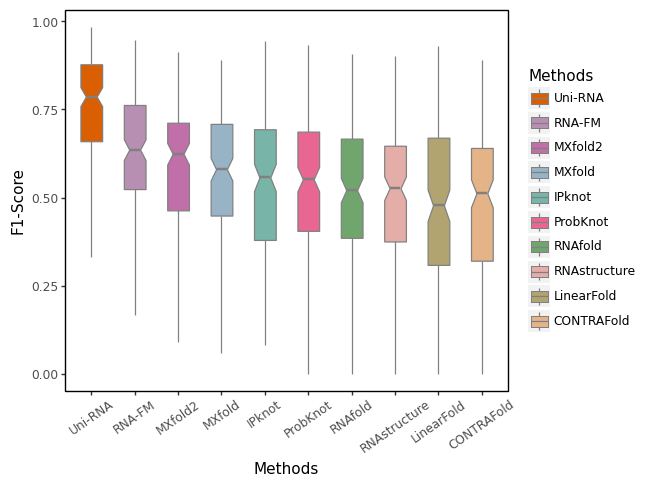

In [18]:
import pandas as pd
import random
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_x_discrete, \
    theme, element_text, stat_summary, scale_fill_manual, scale_color_manual, element_line, element_rect, geom_errorbar

def plot_box(scores, method_names):
    """
    使用 plotnine 绘制盒型图以比较不同方法的性能。
    """
    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Methods', 'Score'])

    # 将得分数据添加到DataFrame中
    for method_name, score_list in zip(method_names, scores):
        temp_df = pd.DataFrame({
            'Methods': [method_name] * len(score_list),
            'Score': score_list
        })
        df = pd.concat([df, temp_df], ignore_index=True)

    # 计算每种方法的平均分数并按这些分数排序
    mean_scores = df.groupby('Methods').mean().sort_values('Score', ascending=False)
    sorted_methods = mean_scores.index.tolist()

    # 重新排序原始DataFrame
    df['Methods'] = pd.Categorical(df['Methods'], categories=sorted_methods, ordered=True)
    df = df.sort_values('Methods')
    
    # 计算每个 'Methods' 的四分位数
    Q1 = df.groupby('Methods')['Score'].quantile(0.25)
    Q3 = df.groupby('Methods')['Score'].quantile(0.75)
    IQR = Q3 - Q1

    # 剪裁超过一定范围的值
    df_outlier_removed = df.copy()
    for method in df['Methods'].unique():
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] < (Q1[method] - 1.5 * IQR[method])), 'Score'] = Q1[method] - 1.5 * IQR[method]
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] > (Q3[method] + 1.5 * IQR[method])), 'Score'] = Q3[method] + 1.5 * IQR[method]

    plot = (
    ggplot(df_outlier_removed, aes(x='Methods', y='Score')) +
    geom_boxplot(aes(fill='Methods'), notch=True, width=0.5, color='gray', outlier_alpha=0.3, outlier_color="#97B3C5") +  # 设置盒型图的填充颜色和边缘颜色
    labs(x='Methods', y='F1-Score') +
    scale_fill_manual(values=color_dict) + 
    scale_x_discrete(limits=sorted_methods) +
    theme(
        axis_text_x=element_text(angle=35, hjust=4),
        panel_background=element_rect(fill='white'),  # 设置背景颜色为白色
        # panel_grid_major=element_line(color='grey', linetype="dashed"),  # 设置主要网格线颜色为灰色
        # panel_grid_minor=element_line(color='black', linetype="dashed"),  # 设置次要网格线颜色为浅灰色
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)
    return plot

if "SPOTRNA" in all_method:
    all_method.remove("SPOTRNA")

method_names = ["Uni-RNA", "RNA-FM"] + all_method

if not os.path.exists("data-for-draw-idt5-box-pk-sample.pkl"):
    scores = [unirna_score_pk_sample, fm_score_pk_sample] + methods_score_pk_sample
    with open("data-for-draw-idt5-box.pkl", "wb+") as f:
        pickle.dump(scores, f)
else:
    scores = pickle.load(open("data-for-draw-idt5-box-pk-sample.pkl", "rb"))
    
plot = plot_box(scores, method_names)
plot.save("idt5-box-pk-sample.svg", dpi=600)
plot.draw()

In [19]:
for i in range(len(method_names)):
    print(method_names[i], np.mean(scores[i]))

Uni-RNA 0.7268679257270155
RNA-FM 0.6048865005387523
IPknot 0.5367027166679263
ProbKnot 0.5315911618181325
MXfold2 0.5842611242099106
MXfold 0.5581416500627495
RNAstructure 0.5055151764831216
LinearFold 0.4877741660535117
RNAfold 0.5172993656949972
CONTRAFold 0.4751233279641347


#### Pseudoknot-free

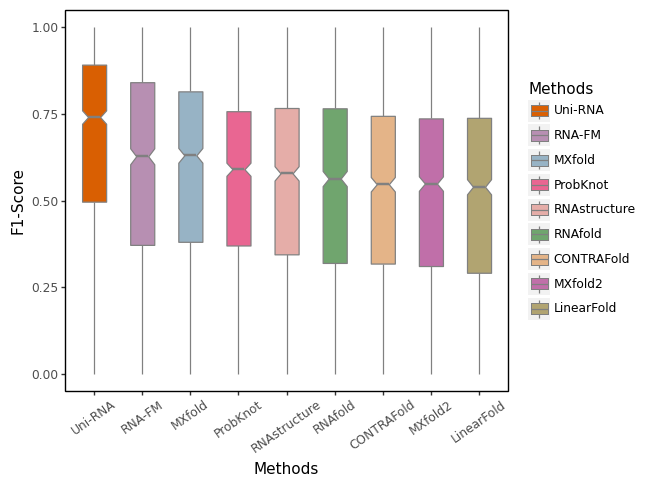

In [20]:
import pandas as pd
import random
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_x_discrete, \
    theme, element_text, stat_summary, scale_fill_manual, scale_color_manual, element_line, element_rect, geom_errorbar

def plot_box(scores, method_names):
    """
    使用 plotnine 绘制盒型图以比较不同方法的性能。
    """
    # 创建一个空的DataFrame
    df = pd.DataFrame(columns=['Methods', 'Score'])

    # 将得分数据添加到DataFrame中
    for method_name, score_list in zip(method_names, scores):
        temp_df = pd.DataFrame({
            'Methods': [method_name] * len(score_list),
            'Score': score_list
        })
        df = pd.concat([df, temp_df], ignore_index=True)

    # 计算每种方法的平均分数并按这些分数排序
    mean_scores = df.groupby('Methods').mean().sort_values('Score', ascending=False)
    sorted_methods = mean_scores.index.tolist()

    # 重新排序原始DataFrame
    df['Methods'] = pd.Categorical(df['Methods'], categories=sorted_methods, ordered=True)
    df = df.sort_values('Methods')
    
    # 计算每个 'Methods' 的四分位数
    Q1 = df.groupby('Methods')['Score'].quantile(0.25)
    Q3 = df.groupby('Methods')['Score'].quantile(0.75)
    IQR = Q3 - Q1

    # 剪裁超过一定范围的值
    df_outlier_removed = df.copy()
    for method in df['Methods'].unique():
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] < (Q1[method] - 1.5 * IQR[method])), 'Score'] = Q1[method] - 1.5 * IQR[method]
        df_outlier_removed.loc[(df_outlier_removed['Methods'] == method) & (df_outlier_removed['Score'] > (Q3[method] + 1.5 * IQR[method])), 'Score'] = Q3[method] + 1.5 * IQR[method]
    
    plot = (
    ggplot(df_outlier_removed, aes(x='Methods', y='Score')) +
    geom_boxplot(aes(fill='Methods'), notch=True, width=0.5, color='gray', outlier_alpha=0.3, outlier_color="#97B3C5") +  # 设置盒型图的填充颜色和边缘颜色
    # stat_summary(fun_data='median_hilow', geom='errorbar', color='red', width=0.2) +  # 添加平均线
    # geom_jitter(color="#97B3C5", width=0.1, size=0.5, alpha=0.1) +  # 设置散点的颜色
    labs(x='Methods', y='F1-Score') +
    scale_fill_manual(values=color_dict) + 
    scale_x_discrete(limits=sorted_methods) +
    theme(
        axis_text_x=element_text(angle=35, hjust=4),
        panel_background=element_rect(fill='white'),  # 设置背景颜色为白色
        # panel_grid_major=element_line(color='grey', linetype="dashed"),  # 设置主要网格线颜色为灰色
        # panel_grid_minor=element_line(color='black', linetype="dashed"),  # 设置次要网格线颜色为浅灰色
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)
    return plot

# 示例数据
if "SPOTRNA" in all_method:
    all_method.remove("SPOTRNA")
    
if "IPknot" in all_method:
    all_method.remove("IPknot")

method_names = ["Uni-RNA", "RNA-FM"] + all_method

if not os.path.exists("data-for-draw-idt5-box.pkl"):
    scores = [unirna_score, fm_score] + methods_score
    with open("data-for-draw-idt5-box.pkl", "wb+") as f:
        pickle.dump(scores, f)
else:
    scores = pickle.load(open("data-for-draw-idt5-box.pkl", "rb"))
    
plot = plot_box(scores, method_names)
plot.save("idt5-box.svg", dpi=600)
plot.draw()

In [21]:
len(scores[0])

1041

In [22]:
for i in range(len(method_names)):
    print(method_names[i], np.mean(scores[i]))

Uni-RNA 0.6678832671032261
RNA-FM 0.584253203393341
ProbKnot 0.5451596455840794
MXfold2 0.5163045808377087
MXfold 0.5822840208567862
RNAstructure 0.5421829523084306
LinearFold 0.5118863555149192
RNAfold 0.5264216203017817
CONTRAFold 0.5231097211991794


### F1 versus Length

In [31]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_boxplot, geom_jitter, labs, scale_fill_manual, theme, element_text, element_rect

# 假设 original_data 是包含原始方法数据的 DataFrame
original_data = pd.DataFrame({'sample_length': length_list, 'f1_score': scores[0], 'method': 'Uni-RNA'})

# 假设 new_method_data 是包含新方法数据的 DataFrame
new_method_data = pd.DataFrame({'sample_length': length_list, 'f1_score': scores[1], 'method': 'RNA-FM'})

rnafold_method_data = pd.DataFrame({'sample_length': length_list, 'f1_score': scores[-2], 'method': 'RNAfold'})

# 合并两个数据集
combined_data = pd.concat([original_data, new_method_data, rnafold_method_data])
combined_data['method'] = pd.Categorical(combined_data['method'], categories=['Uni-RNA', 'RNA-FM', 'RNAfold'], ordered=True)

# 进行数据的下采样，只用于绘制散点
sampled_data = combined_data.groupby('method').apply(lambda x: x.sample(frac=0.05)).reset_index(drop=True)

# 处理异常值
Q1 = combined_data.groupby('method')['f1_score'].quantile(0.25)
Q3 = combined_data.groupby('method')['f1_score'].quantile(0.75)
IQR = Q3 - Q1

for method in combined_data['method'].unique():
    method_filter = combined_data['method'] == method
    score_filter = ((combined_data['f1_score'] < (Q1[method] - 1.5 * IQR[method])) | (combined_data['f1_score'] > (Q3[method] + 1.5 * IQR[method])))
    combined_data.loc[method_filter & score_filter, 'f1_score'] = np.nan  # 可选：将异常值设为NaN或进行其他处理

# 创建长度区间
combined_data['length_group'] = pd.cut(combined_data['sample_length'], bins=[0, 50, 100, 200, 500, np.inf], labels=['0-50', '51-100', '101-200', '201-500', '501+'])

group_counts = combined_data.groupby('length_group').size().reset_index(name='counts')
title_with_counts = 'F1 Scores by Sequences Length and Method\n' + \
    '\n'.join([f"{row['length_group']}: {row['counts']} samples" for index, row in group_counts.iterrows()])

In [32]:
print(title_with_counts)

F1 Scores by Sequences Length and Method
0-50: 0 samples
51-100: 1263 samples
101-200: 1152 samples
201-500: 627 samples
501+: 81 samples


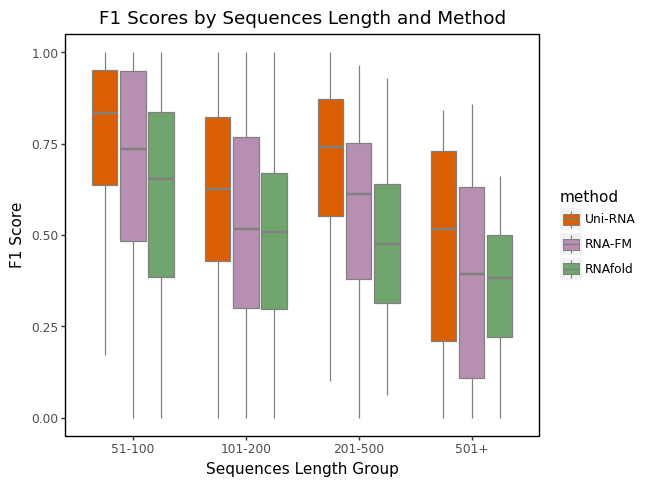

In [34]:
# 绘制组合箱线图
plot = (ggplot(combined_data) +
        aes(x='length_group', y='f1_score', fill='method') +
        geom_boxplot(color='gray', outlier_alpha=0., outlier_color="#97B3C5") +
        labs(x='Sequences Length Group', y='F1 Score', title='F1 Scores by Sequences Length and Method') +
        theme(
              panel_background=element_rect(fill='white'),
              panel_border=element_rect(color="black", fill=None, size=1)) +
        
        scale_fill_manual(values=color_dict))

plot.save("idt5-box-length.png", dpi=600)
plot.draw()

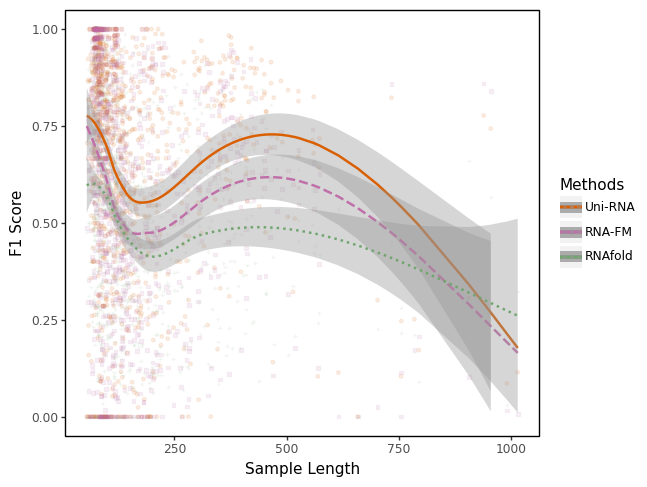

In [27]:
import pandas as pd
from plotnine import ggplot, aes, geom_point, geom_smooth, scale_shape_manual, scale_color_manual, scale_linetype_manual, labs, ylim, theme, element_rect

# 创建图表
plot = (
    ggplot() +
    geom_point(
        data=combined_data, 
        mapping=aes(x='sample_length', y='f1_score', color='method', shape='method'), 
        alpha=0.1, 
        size=1
    ) +
    geom_smooth(
        data=original_data, 
        mapping=aes(x='sample_length', y='f1_score', color='method'), 
        method='loess', 
        linetype='solid' # 为 UniRNA 设置实线
    ) +
    geom_smooth(
        data=new_method_data, 
        mapping=aes(x='sample_length', y='f1_score', color='method'), 
        method='loess', 
        linetype='dashed' # 为 RNA-FM 设置虚线
    ) +
    geom_smooth(
        data=rnafold_method_data, 
        mapping=aes(x='sample_length', y='f1_score', color='method'), 
        method='loess', 
        linetype='dotted' # 为 RNAFold 设置点线
    ) +
    scale_color_manual(values=['#D95F02', '#C06FA9', '#70A56E']) +  # 自定义颜色
    scale_shape_manual(values=["o", "s", "+"]) +  # 为不同方法分配不同的形状
    labs(x='Sample Length', y='F1 Score', color='Methods', shape='Methods') +
    ylim(0, 1) +
    theme(
        panel_background=element_rect(fill='white'),
        panel_border=element_rect(color="black", fill=None, size=1)
    )
)

plot.save("length_unirna_vs_bh5.svg", dpi=600)
plot.draw()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个数据框
import pandas as pd
data_unirna = pd.DataFrame({'unirna': unirna_score})
data_fm = pd.DataFrame({'rnafm': fm_score})
data_mxfold = pd.DataFrame({"mxfold": methods_score[0]})

# 使用 Seaborn 的 kdeplot 绘图，并将两个分布叠加到一起
sns.set(style="white", color_codes=True)

# 绘制 unirna 的分布
sns.kdeplot(data=data_unirna, x="unirna", label="unirna", fill=True)

# 绘制 rnafm 的分布
sns.kdeplot(data=data_fm, x="rnafm", label="rnafm", fill=True)
sns.kdeplot(data=data_mxfold, x="mxfold", label="mxfold", fill=True)

# 添加轴标签
plt.xlabel("F1 Scores")
# 显示图形
plt.legend()
plt.show()


## Show case

In [ ]:
import numpy as np

data_label = pickle.load(open(data_list, "rb"))
data_dir = "/home/siduanmiao/benchmark/changeformatdata"
benchmark_name = "benchmark_1_0.75_length_level.pkl"
all_method = os.listdir(data_dir)
all_method.remove("SPOTRNA")

all_stru_unirna = []
all_stru_fm = []
all_stru = []
methods_stru = []

for i in range(len(data_label)):
    id = data_label[i]['id']
    label = data_label[i]['label']
    all_stru.append(label)
    
    pred = np.array(result_unirna["label"][i])
    all_stru_unirna.append(pred)
    
    pred = np.array(result_fm["label"][i])
    all_stru_fm.append(pred)
        
for method in all_method:
    single_method = []
    method_path = os.path.join(data_dir, method, benchmark_name)
    data = pickle.load(open(method_path, "rb"))
    
    for i in range(len(data_label)):
        seq = data_label[i]['seq']
        method_pred = np.array(data[i]["label"])
        single_method.append(method_pred)
    methods_stru.append(single_method)

In [ ]:
import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def infer_rna(data_label: list, save_path: str):
    meta_idt = []

    for idx in range(len(data_label)):
        seq = data_label[idx]["seq"]
        label = data_label[idx]["label"]
        id = data_label[idx]["id"].replace("/", "")
        pred_unirna = all_stru_unirna[idx]
        pred_unirna_apc = apc(torch.from_numpy(pred_unirna)).numpy()
        pred_fm = all_stru_fm[idx]
        pred_mxfold2 = methods_stru[1][idx]
        pred_rnafold = methods_stru[-2][idx]
        f1_unirna = f1_score(np.where(pred_unirna > 0.5, 1, 0).reshape(-1), label.reshape(-1))
        f1_unirna_apc = f1_score(np.where(pred_unirna_apc > 0.5, 1, 0).reshape(-1), label.reshape(-1))
        f1_fm = f1_score(np.where(pred_fm > 0.5, 1, 0).reshape(-1), label.reshape(-1))
        f1_mxfold2 = f1_score(np.where(pred_mxfold2 > 0.5, 1, 0).reshape(-1), label.reshape(-1))
        f1_rnafold = f1_score(np.where(pred_rnafold > 0.5, 1, 0).reshape(-1), label.reshape(-1))
        if (f1_unirna - f1_mxfold2 > 0.1 and f1_unirna - f1_rnafold > 0.1 and f1_unirna - f1_fm > 0.1) or "PDB" in id:
            meta_idt.append(
                {
                    "seq": seq,
                    "id": id,
                    "label": label,
                    "unirna": pred_unirna,
                    "mxfold2": pred_mxfold2,
                    "rnafold": pred_rnafold,
                    "fm": pred_fm
                }
            )
            # fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
            # ax1.imshow(label)
            # ax1.set_title("Ground Truth")  # Corrected line
            # ax2.imshow(pred_unirna)
            # ax2.set_title("UniRNA")       # Corrected line
            # ax3.imshow(pred_mxfold2)
            # ax3.set_title("mxfold2")      # Corrected line
            # ax4.imshow(pred_rnafold)
            # ax4.set_title("RNAfold")      # Corrected line
            # ax5.imshow(pred_fm)
            # ax5.set_title("RNA-FM")
            # ax6.imshow(pred_unirna_apc)
            # ax6.set_title("UniRNA_APC")
            # fig.savefig(f"./idt_mat_addpdb/idx_{idx}_id_{id}.png", dpi=600)
            os.makedirs(f"./idt_dbn", exist_ok=True)
            with open(f"./idt_dbn/idx_{idx}_id_{id}.dbn", "w+") as f:
                f.write(">label\n")
                f.write(seq + "\n")
                f.write(convert_matrix_to_dotbracket(label) + "\n")
                f.write(">UniRNA\n")
                f.write(seq + "\n")
                f.write(convert_matrix_to_dotbracket(np.where(pred_unirna > 0.5, 1, 0)) + "\n")
                f.write(">mxfold2\n")
                f.write(seq + "\n")
                f.write(convert_matrix_to_dotbracket(np.where(pred_mxfold2 > 0.5, 1, 0)) + "\n")
                f.write(">RNAfold\n")
                f.write(seq + "\n")
                f.write(convert_matrix_to_dotbracket(np.where(pred_rnafold > 0.5, 1, 0)) + "\n")
                f.write(">RNA-FM\n")
                f.write(seq + "\n")
                f.write(convert_matrix_to_dotbracket(np.where(pred_fm > 0.5, 1, 0)) + "\n")
                f.write(">UniRNA_APC\n")
                f.write(seq + "\n")
                f.write(convert_matrix_to_dotbracket(np.where(pred_unirna_apc > 0.5, 1, 0)) + "\n")
                
    with open(save_path, "wb+") as f:
        pickle.dump(meta_idt, f)

In [ ]:
infer_rna(data_label, "idt5.pkl")